# A Modern Introduction to Tensorflow (Advanced ML 2018)

*\[Some brief acknowledgments - this tutorial has been adapted from a few tutorials done by <a href="https://github.com/wendazhou">Wenda Zhou</a> (including one created for last year's iteration of this course), so thanks to him!\]*

This notebook is a quick (i.e about 75 minutes) introduction to <a href="https://www.tensorflow.org/">Tensorflow</a>, from the point of view of using Tensorflow via Python notebooks, and in particular doing so via Google's <a href="https://colab.research.google.com/">Colab</a>. Tensorflow is an open source framework for **high performance machine learning** - while you don't need Tensorflow to run a logistic regression (although as we'll see, you can easily do so), you'll need something like it to perform the heavy lifting for the types of models we'll come across in the second half of the course.

From a technical standpoint, Tensorflow combines the following:

*   the ability to define computations in a symbolic manner and extract derivatives automatically by back-propagation;
*   the ability to execute these operations on a variety of hardware, including GPUs and TPUs (GPUs are great for general purpose parallization; TPUs are great at multipling tensors together, which happens *a lot* when training deep networks).

The benefit to you is that this allows you to focus on

* specifying the model (i.e the architecture of your neural network);
* specifying the loss (e.g cross entropy for classifcation, squared loss for regression etc); and
* specifying the mode of training (e.g SGD, Adam etc);

rather than the technical aspects of the implementation of the training procedure. I'll also briefly introduce a diagnostic tool called <a href="https://www.tensorflow.org/guide/summaries_and_tensorboard">Tensorboard</a>, which will be helpful for examining the progress of the training procedure of your model.

## Prerequisites
In the tutorial, I'll be assuming 

* that you're comfortable (or at least, not uncomfortable) with Python 3 - see the <a href="https://github.com/ikinsella/AdvML-Fall-18/blob/master/python_tutorial/Tutorial.ipynb">tutorial from the start of the semester</a> if you'd like a refresher;
* that you have an understanding of the content from the 'Neural Networks' section from the first half of the course. (If you don't feel comfortable with it, I highly recommend investing some time now making yourself so, as the next half of the course is going to build on this *a lot*.)

I'll also be assuming that you're running the tutorial in Colab. The main benefit of this is that this will not require any installation of Tensorflow. 

If you want to run this locally, then you will need to <a href="https://www.tensorflow.org/install/">install Tensorflow and Tensorboard yourself</a>. **WARNING: We will not provide ANY assistance if you have issues installing or running Tensorflow locally on your laptop.** (If you are using Colab, the hardware factor in diagnosing e.g bugs in code is removed, and it's suprising how frequently this can be a factor.)

# Using Tensorflow in Colab

Both Tensorflow and Colab are made by Google; therefore you'd hope that using Tensorflow in Colab is straighforward. As we'll see, other than a few things we'll need to keep in mind, the answer is yes. To begin, note that Tensorflow and Tensorboard already come pre-loaded on the virtual machine we're currently running this notebook on:

In [1]:
!pip list


Package                  Version   
------------------------ ----------
absl-py                  0.5.0     
altair                   2.2.2     
astor                    0.7.1     
beautifulsoup4           4.6.3     
bleach                   3.0.2     
cachetools               2.1.0     
certifi                  2018.10.15
chardet                  3.0.4     
crcmod                   1.7       
cycler                   0.10.0    
cymem                    2.0.2     
cytoolz                  0.9.0.1   
decorator                4.3.0     
defusedxml               0.5.0     
dill                     0.2.8.2   
entrypoints              0.2.3     
filelock                 3.0.9     
future                   0.16.0    
gast                     0.2.0     
google-api-core          1.5.0     
google-api-python-client 1.6.7     
google-auth              1.4.2     
google-auth-httplib2     0.0.3     
google-auth-oauthlib     0.2.0     
google-cloud-bigquery    1.1.0     
google-cloud-core        0.2

Now that we know that Tensorflow is installed, we can import it using `import tensorflow as tf` and proceed.

# Basics of Tensorflow: Dataflow graphs

In Tensorflow, everything* lives in a graph. This shouldn't suprise you too much - neural networks were introduced to you via a graphical representation as a good way of thinking about them conceptually, and this perspective is beneficial from a computational perspective too. However, this means we'll need to write our scripts/programs in a slightly different way then what you'll be used to using vanilla Python.

\* For now, at least. I'm intentionally ignoring "eager execution" in TF, where the 'graph building' will be hidden behind the scenes. Although future versions of Tensorflow (from 2.0) will default to eager execution, it's not completely there yet.

## A motivating example

I'll introduce the difference via an example. Let us suppose that we were interested in sampling a single $\mathcal{N}(3, 4)$ random variable via Tensorflow. In regular Python, we could just use NumPy and write

In [2]:
import numpy as np

a = 2.0*np.random.normal() + 3.0
print(a)

5.074186798694685


which is simple enough. However, in Tensorflow, when we say that everything lives in a graph, we really do mean **everything**. If we just try and naively repeat what we did above, except using the Tensorflow analogues of e.g `np.random.normal`, we get the following:

In [3]:
import tensorflow as tf

a_tf = 2.0*tf.random_normal(shape=[]) + 3.0
print(a_tf)

Tensor("add:0", shape=(), dtype=float32)


Rather than getting a numerical value, we're instead getting something called a `Tensor` object (more on those later). So, what is happening here? In e.g *NumPy*, variables store values and *operators execute operations*:

In [4]:
a = 2*np.random.normal()    # a is a variable, * and np.random.normal() 
                            # are operators
b = np.array([3])           # b is a variable, np.array() is a operator
c = np.add(a, b)            # c is a variable storing the result of the 
                            # execution of np.add on a and b

print(c)                    # Note that as c is a variable, printing it twice
print(c)                    # gives the same thing twice

[1.42015094]
[1.42015094]


whereas **in Tensorflow**, **operators define the result of an operation,** and we must **explicitly** ask Tensorflow to perform the computation:

In [5]:
tf.reset_default_graph()
a_tf = tf.multiply(2.0, tf.random_normal(shape=[])) # a_tf stores the op of
                                                    # sampling a N(0, 4)
b_tf = tf.constant(3.0)    # b_tf stores the op of creating a node = 3
c_tf = tf.add(a_tf, b_tf)  # c_tf stores the op of a_tf + b_t

print(c_tf)                   # Thus printing c_tf gives us a Tensor object...

with tf.Session() as sess:
  print(sess.run(c_tf))       # and then we only get the result after evaluation
  print(sess.run(c_tf))       # Evaluating again gives us a different result!

Tensor("Add:0", shape=(), dtype=float32)
3.4947917
8.961396


## The default graph

Note that in the above code, we haven't specified a graph - we've simply started building it on a global graph created by default by Tensorflow. This can be potentially undesirable; for example, if you run the following code block several times, you'll see that the output changes several times. 

In [6]:
x = tf.constant(4, name='a')
x

<tf.Tensor 'a:0' shape=() dtype=int32>

This is because a constant named `a` already exists; as the name must be unique, the name gets changed. Another example (which ends up causing an error) is the following code. Run this twice, and compare what happens the first and second time you run it.

In [0]:
x = tf.get_variable('a', initializer=0)

Because of this, it is recommended to explicitly set a default graph via the use of a `with` block; this helps to avoid some otherwise hard to diagnose errors like what occurs above:

In [7]:
# Note that running this command severl times doesn't change what the output is
with tf.Graph().as_default():
    x = tf.constant(4, name='a')
x

<tf.Tensor 'a:0' shape=() dtype=int32>

It is also possible to reset the current graph via `tf.reset_default_graph`, or by restarting the kernel. If you have a bug in your code and you suspect it has something to do with the graph construction process, the latter is usually a good first step in trying to debug.

## Executing your code - sessions

In order to execute your code, Tensorflow uses the notion of a `tf.Session` in order to execute the computations you've described when building a graph. (The 'behind the hood' reason for this is that Tensorflow needs to manage the resources allocated to the computation, which becomes very important when you begin involving the GPU as part of performing calculations.)
 
In most cases (in particular, ones you will come across in this course), it is best to cleanly seperate the definition of the computation (i.e building the graph) to it's execution. This can be done in the following way:

In [8]:
with tf.Graph().as_default():
    x = tf.constant('Hello world')     # We build the graph within a 'with' 
                                       # block as discussed before
    with tf.Session() as sess:
        print(sess.run(x))       # We then tell Tensorflow to begin computing

b'Hello world'


It is worth remembering that each graph may only correspond to one session, and moreover we must create the session with the default graph being in scope. This means that the following code won't work, as the session is being run outside of the scope of the default graph:

In [0]:
with tf.Graph().as_default():
    x = tf.constant('Hello world')
    
with tf.Session() as sess:
    print(sess.run(x)) 

As you'll likely be spending all of your time in a notebook, there is also a notion of a `tf.InteractiveSession` which is useful. (The only difference is that an `InteractiveSession` installs itself as the default session, meaning we can call e.g `x.run()` without having to pass a specific `Session` object. )

## Further information

If you want more detail as to the specifics of graphs in Tensorflow and what is happening under the hood, I highly recommend looking at the <a href="https://www.tensorflow.org/guide/graphs">Graphs and Sessions</a> section on the Tensorflow website.

# Basics of Tensorflow: Tensors

As hinted by the name, Tensorflow is designed to compute on **tensors**. (I don't know where the 'flow' part of the name comes from, however.) As this isn't a math course, for us tensors are simply multidimensional arrays of numerical data. If you're used to Numpy, then these are basically the Tensorflow version of `np.ndarry`. Tensors are characterized by two properties:

*   a **datatype** - this is usually `tf.float32` or `tf.int32` (note: these have a `tf.` prefix!)
*   the **shape** - this could be e.g $10 \times 4$, $10 \times 20 \times 30$ etc.

Let's try and contextualize this. Consider the following image taken from the ImageNet dataset:

![A picture of a panda from ImageNet. Sorry it isn't showing for you.](https://www.tensorflow.org/images/cropped_panda.jpg)

How can we store this as a tensor? (Note: If we want our neural networks to try and do computer vision tasks such as image recognition, we're going to need to be able to do this.) As the image is $100$ pixels by $100$ pixels, we can store this as a $100 \times 100 \times 3$ tensor:

* the first two dimensions of the array correspond to a $(x, y)$ coordinate of a pixel;
* the last dimension corresponds to the **R**ed, **G**reen and **B**lue channels of the image.

In terms of the datatype, this could be either `tf.int32` (for example, if the image is 24 bit - so there are 8 bits per channel - then the entries will be an integer between $0$ and $255 = 2^8 - 1$) or a `tf.float32` (if we have images of different bit-depths, we will want to normalize them to lie in a range $[0, 1]$ so that our model is agnostic to this). 





## Important types of tensors

In Tensorflow, there are several types of tensors which you will come across. The two main ones to keep in mind are:

*   `tf.Variable` - Variables can be assigned values, and importantly these will be remembered across **several calls** to `session.run`. This will be used for the weights and biases in the network. (Why? If you think of one call of `session.run` as corresponding to one step of the optimization algorithm used to train your neural network, then you'd like to remember the weights/biases after each step!)
*   `tf.placeholder` - Placeholders are given values only at runtime (when `session.run` is called), which will allow us to pass arguments to the Tensorflow operations we are about to use. For example, we can then use this to pass the training data into our model so we can then try and fit it.

We can see the difference between the two by running the two code blocks below:

In [9]:
# tf.Variable example

with tf.Graph().as_default():
    # Create a variable with initial value 4
    a = tf.get_variable('variable_1', initializer = 4)
    
    # This operation represents subtracting one from a and then reassigning
    # it to a. Note that it does not run it!
    subtract_a = tf.assign(a, a - 1)
    
    with tf.Session() as sess:
        # Note that variables must be initialized before they are used!
        sess.run(tf.global_variables_initializer())
        print(sess.run(a))
        sess.run(subtract_a)
        print(sess.run(a))
        sess.run(subtract_a)
        print(sess.run(a))

4
3
2


In [10]:
# tf.placeholder example

with tf.Graph().as_default():
    # We need to define the shape of the placeholder.
    # Use none to indicate that the extent is unknown
    a = tf.placeholder(tf.float32, shape=[None])
    
    sum_a = tf.reduce_sum(a)
    
    with tf.Session() as sess:
        # We provide the data when running using the feed_dict
        print(sess.run(sum_a, feed_dict={a: [1, 2, 3]}))
        print(sess.run(sum_a, feed_dict={a: [4, 5, 6]}))

6.0
15.0


## Operations on tensors

Tensorflow provides several pre-defined operations on tensors - pointwise arithmetic, tensor inner products, conolutions, pretty much anything you'd want. One thing worth noting is that, much like e.g NumPy, Tensorflow overloads the normal Python operators such as `+`, and so you should be careful of the exact semantics of the overload if you do use them.

In [11]:
tf.reset_default_graph()      
a = tf.constant([[0, 1], [2,3]], dtype=tf.float32)
b = tf.constant([[1, 2], [3, 4]], dtype=tf.float32)

matmul = tf.matmul(a, b)         # Multiplying two matrices
matadd = tf.add(a, b)            # Adding two tensors together
matadd_od = a + b                # Adding two tensors together, but using + 
                                 # (this is overloaded by Tensorflow)

with tf.Session() as sess:
    print(sess.run(matmul))
    print(sess.run(matadd))       
    print(sess.run(matadd_od))

[[ 3.  4.]
 [11. 16.]]
[[1. 3.]
 [5. 7.]]
[[1. 3.]
 [5. 7.]]


# An example: Logistic Regression

As promised earlier, here we'll go through an example of using Tensorflow to perform a simple logistic regression in order to classify handwriting digits. By doing so, we'll identify the key APIs which will end up being helpful for you to end up building and fitting models to a given dataset. 

(Note: The use of these APIs is most useful for when it comes to your projects - don't worry if this is a bit confusing at first! Your homeworks will be styled in a 'fill in this section of code' fashion to help you get used to what is happening in Tensorflow - remember that the point of this course is to teach you about machine learning, not programming.)

## Digit recognition on MNIST

In any postal/package delivery company (e.g USPS, UPS, FedEx), they will frequently recieve letters and parcels whose delivery addresses are **handwritten**. Now, 50 years ago these would be sorted by hand, and for the standards of 50 years ago, this did a good job. However, nowadays 

* the expected timeframe for deliveries is far shorter (within a few days), and
* the scale of distribution is far greater (both in terms of volume and the possible places packages can be sent to in the world),

and so we need an automated solution in order to read handwriting and figure out where we should send the letter to. We also want our automated solution to have a lower error rate.

A simplified version of this problem is to simply infer handwritten digits, and the classical example of a dataset which consists of handwritten digits is the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The method of collection isn't too important for now - all which we need to know is that

* there are 50,000 training examples
* there are 10,000 test examples
* each handwritten digit is given by a 28px by 28px greyscale image, along with a classification label from 0 to 9.

As you'll see soon in the course, it's far better to use e.g a convolutional neural network on this type of task. For now though at least, we'll just fit a simple logistic classifier to see how to do so in Tensorflow. 

## Loading data: the dataset API

The dataset API (`tf.data`) is the main method - and also the best practice way - for loading data into Tensorflow. It works with simple text files, binary files, and tfrecord files (think of the latter as a special proprietary format for importing data into Tensorflow). You can also directly load data from NumPy arrays, but this does not scale well. 

One useful thing to note is that there are pre-existing files or conversion utilities for the MNIST, CIFAR and Imagenet datasets. I'll go through [some example code provided for the MNIST example](https://github.com/tensorflow/models/blob/master/official/mnist/dataset.py), so then we can see what is happening under the hood.

We'll begin by downloading the data. Note that if you look under "Files > sample_data" you'll come across a smaller version of the MNIST dataset. However, it'll be good to know how to import other data sets from online - remember that we're working on a Google VM, not locally!

In [12]:
# Downloading the data - most of this can be ignored for our purposes
import gzip
import os
import shutil
import tempfile

import numpy as np
from six.moves import urllib
import tensorflow as tf


def read32(bytestream):
  """Read 4 bytes from bytestream as an unsigned 32-bit integer."""
  dt = np.dtype(np.uint32).newbyteorder('>')
  return np.frombuffer(bytestream.read(4), dtype=dt)[0]


def check_image_file_header(filename):
  """Validate that filename corresponds to images for the MNIST dataset."""
  with tf.gfile.Open(filename, 'rb') as f:
    magic = read32(f)
    read32(f)  # num_images, unused
    rows = read32(f)
    cols = read32(f)
    if magic != 2051:
      raise ValueError('Invalid magic number %d in MNIST file %s' % (magic,
                                                                     f.name))
    if rows != 28 or cols != 28:
      raise ValueError(
          'Invalid MNIST file %s: Expected 28x28 images, found %dx%d' %
          (f.name, rows, cols))


def check_labels_file_header(filename):
  """Validate that filename corresponds to labels for the MNIST dataset."""
  with tf.gfile.Open(filename, 'rb') as f:
    magic = read32(f)
    read32(f)  # num_items, unused
    if magic != 2049:
      raise ValueError('Invalid magic number %d in MNIST file %s' % (magic,
                                                                     f.name))


def download(directory, filename):
  """Download (and unzip) a file from the MNIST dataset if not already done."""
  filepath = os.path.join(directory, filename)
  if tf.gfile.Exists(filepath):
    return filepath
  if not tf.gfile.Exists(directory):
    tf.gfile.MakeDirs(directory)
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  url = 'https://storage.googleapis.com/cvdf-datasets/mnist/' + filename + '.gz'
  _, zipped_filepath = tempfile.mkstemp(suffix='.gz')
  print('Downloading %s to %s' % (url, zipped_filepath))
  urllib.request.urlretrieve(url, zipped_filepath)
  with gzip.open(zipped_filepath, 'rb') as f_in, \
      tf.gfile.Open(filepath, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)
  os.remove(zipped_filepath)
  return filepath

download('data/', 'train-images-idx3-ubyte')
download('data/', 'train-labels-idx1-ubyte')

'data/train-labels-idx1-ubyte'

Note that this was relatively painless! You might need to be careful if your session times out and Colab clears it out, but otherwise there is nothing to worry about - in particular, as the code below shows, we don't need to refer to it by however it is saved in the `/tmp/` directory. 

Let's have a quick look at the dataset and look through it:

In [13]:
with tf.Graph().as_default():
    dataset = tf.data.FixedLengthRecordDataset('data/train-images-idx3-ubyte', 
                                               28 * 28, header_bytes=16)
    iterator = dataset.make_one_shot_iterator()
    next_sample = iterator.get_next()
    
    with tf.Session() as session:
        print(session.run(next_sample))
        print(len(session.run(next_sample)))

b"\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x12\x12\x12~\x88\xaf\x1a\xa6\xff\xf7\x7f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1e$^\x9a\xaa\xfd\xfd\xfd\xfd\xfd\xe1\xac\xfd\xf2\xc3@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x001\xee\xfd\xfd\xfd\xfd\xfd\xfd\xfd\xfd\xfb]RR8'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x12\xdb\xfd\xfd\xfd\xfd\xfd\xc6\xb6\xf7\xf1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

Currently it's a sequence of bytes, which isn't the most interesting thing in the world. In the case of a logistic regression, we could keep the data as being arranged in this fashion, but for more general models (particularly CNNs) we'll want to convert it to a $28 \times 28 \times 1$ tensor which is more natural:

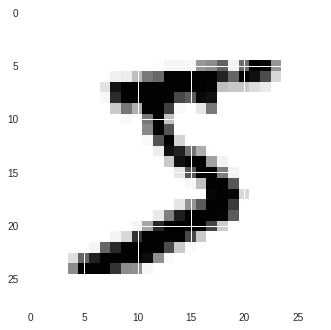

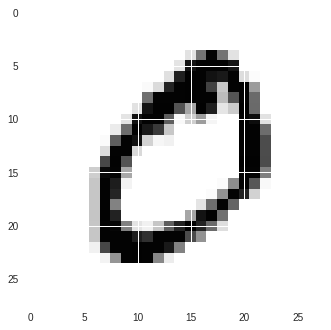

In [14]:
import matplotlib.pyplot as plt

with tf.Graph().as_default():
    # Although our intuition carries across, it is important to always remember
    # that we are working with symbolic computations. In particular, this
    # function, which describes an op that will be executed on each image,
    # is only called once.
    def _format_image(raw_data):
        image = tf.decode_raw(raw_data, tf.uint8)
        image = tf.to_float(image)
        image = tf.reshape(image, [28, 28])
        image = image / 255
        return image
    
    dataset = tf.data.FixedLengthRecordDataset('data/train-images-idx3-ubyte', 
                                               28 * 28, header_bytes=16)
    dataset = dataset.map(_format_image)
    iterator = dataset.make_one_shot_iterator()
    next_sample = iterator.get_next()
    
    with tf.Session() as session:
        plt.imshow(session.run(next_sample))
        plt.show()
        plt.imshow(session.run(next_sample))
        plt.show()

We'll define this as a function, as it'll come in handy later:

In [0]:
def get_mnist_dataset():
    """ This function creates a dataset which can be used to load data 
    from the MNIST dataset. """
    def _format_image(raw_data):
        image = tf.decode_raw(raw_data, tf.uint8)
        image = tf.to_float(image)
        image = tf.reshape(image, [28, 28, 1])
        image = image / 255
        return image
    
    def _format_label(raw_data):
        label = tf.decode_raw(raw_data, tf.uint8)
        label = tf.reshape(label, [])
        return tf.to_int32(label)
    
    dataset_img = tf.data.FixedLengthRecordDataset('data/train-images-idx3-ubyte', 28 * 28, header_bytes=16)
    dataset_img = dataset_img.map(_format_image)
    
    dataset_label = tf.data.FixedLengthRecordDataset('data/train-labels-idx1-ubyte', 1, header_bytes=8)
    dataset_label = dataset_label.map(_format_label)
    
    return tf.data.Dataset.zip((dataset_img, dataset_label))

## Building and training your model: the Estimator API

The estimator API (`tf.estimator`) is the main method to build and train estimators in Tensorflow. It abstracts numerous details about setting up the tensorflow graph and executing the training, whilst also being flexible enough to be workable for most experiments. One peculiarity of the estimator API is that it abstracts the model building behind a function, so we will be working with functions that return functions.

(As an aside, Tensorflow also provides canned estimators - i.e premade estimators - but they are not of interest today.)

The estimator API is based off two notions:

* an input function used to import the data 
* a model function used to create the model when it is called.

We'll begin by looking at an example of a model function:

In [0]:
def model_fn(features, labels, mode):
    # Firstly, begin by noting that the model_fn takes in three arguments:
    # - features: these should be the handwriting digits
    # - labels: the classification label of the digits
    # - mode: this allows us to switch between e.g training and testing

    # Here we're building up the model 
    images = features                            # We begin by taking the images
    images = tf.layers.flatten(images)           # Flattens the input tensor 
                                                 # (except for the batch axis)
    logits = tf.layers.dense(images, units=10)   # Creates a dense connected layer 
    
    # This part of the model function keeps track of the accuracy 
    # as a measure of training progress
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions)
    
    metrics = {'accuracy': accuracy}
    
    # Here we specify the loss function - note that in our last layer, 
    # we're still working on the logit scale
    # (we don't transform them to probabilities)
    loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
    
    # Here we're specifying the training procedure
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    train_op = optimizer.minimize(loss, 
                                  global_step=tf.train.get_or_create_global_step())
    
    # This gives Tensorflow the description of what must be done
    # to construct our model.
    return tf.estimator.EstimatorSpec(
        loss=loss,
        mode=mode,
        train_op=train_op,
        predictions=predictions,
        eval_metric_ops=metrics)

As for the input function, as we've already performed most of the work in the data processing this ends up being pretty straightforward:

In [0]:
# The main things we are doing here are doing some shuffling, batching, 
# and performance tweaks. Don't worry too much about this!
def input_fn():
    dataset = get_mnist_dataset()
    # Shuffle the dataset, and repeat as necessary.
    dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(1000)) 
    dataset = dataset.prefetch(128)
    dataset = dataset.batch(batch_size=128)
    dataset = dataset.prefetch(2)
    
    return dataset

In particular, now that we've got our input function and our model function, we're able to start training! Below we'll begin fitting the model for 500 iterations of gradient descent:

In [18]:
# Note that we are passing functions as arguments to the constructor and train
# functions, and not their return values!
estimator = tf.estimator.Estimator(model_fn=model_fn)
estimator.train(input_fn, steps=500)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpk9dgbnu7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd5e0b7e400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph wa

A few things worth pointing out:

* By default, Tensorflow will ouput the loss after every 100 iterations to the console. If you're running training procedures for hundreds of thousands of iterations, you'll want a better way of visualizing the progress. (We'll get to this later.)
* Note that Tensorflow actually has estimators work from a directory. If this isn't specified, then this goes to a `/tmp/` directory - good luck accessing this on Colab! The next example will have us specify a directory to show that this is possible in Colab. 
* At the end of training, we're given the final loss, but not the classification rate (which is what we really care about in classification problems). With some minor changes, we can output this at the end. 

Lets make some changes to our code to address these last two issues:

In [19]:
# Note: if we want to evaluate our estimator, we must modify the input function
# for that: we don't want to repeat the dataset forever when evaluating!

# We now want a parametrised input function. So we will create a function 
# that creates a function.
def make_input_fn(repeat_count=None, shuffle_size=1000):
    def input_fn():
        dataset = get_mnist_dataset()
        
        # Shuffle the dataset, and repeat as necessary
        if shuffle_size is not None and shuffle_size > 0:
            dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_size, repeat_count))
        else:
            dataset = dataset.repeat(repeat_count)
            
        dataset = dataset.prefetch(128)
        dataset = dataset.batch(batch_size=128)
        dataset = dataset.prefetch(2)
    
        return dataset
    return input_fn

estimator = tf.estimator.Estimator(model_fn=model_fn,
                                   model_dir='models/')
print('\n---- Starting training ------')
estimator.train(make_input_fn(), steps=500)
print('---- Training Done ------')
print('\n---- Starting evaluation ------')
estimator.evaluate(input_fn=make_input_fn(1, 0))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd5e218c0b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

---- Starting training ------
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
IN

{'accuracy': 0.37548333, 'global_step': 500, 'loss': 1.962226}

As you can see from our above attempts, running 500 iterations of (stochastic) gradient descent isn't giving us a good model. If we ran it for a bit longer, we'd get something more reasonable. There is also the possibility that the learning rate (or step size) chosen was too small. If we want to experiment to try and find a good learning rate, we will want this to be an adjustable parameter of our network (so we don't need to constantly redefine a network and copy/paste loads of code). To do so, Tensorflow allows a construction to pass parameters to the model function:

In [20]:
def model_fn(features, labels, mode, params):
    # Here, the params parameter is passed in from Tensorflow
    images = features
    images = tf.layers.flatten(images)
    logits = tf.layers.dense(images, units=10)
    
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions)
    
    metrics = {'accuracy': accuracy}
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=params['learning_rate'])
    train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())
    
    return tf.estimator.EstimatorSpec(
        loss=loss,
        mode=mode,
        train_op=train_op,
        predictions=predictions,
        eval_metric_ops=metrics)

# Note that we pass in a dictionary params into the model function via a 
# separate argument in the tf.estimator.Estimator function
estimator = tf.estimator.Estimator(model_fn=model_fn, params={'learning_rate': 0.5})
print('\n---- Starting training ------')
estimator.train(make_input_fn(), steps=500)
print('---- Training Done ------')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpezaucyf2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd5e1f6b390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

---- Starting training ------
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSave

If we wanted to do something more involved - for example, by specifying a decaying learning rate - then remember that we cannot create it before passing it to the estimator, as it will not be part of the same graph! Thankfully, we can get around this by passing in a function as part of our `params` dictionary:

In [21]:
# This part of code will allow us to easily switch between function/constant 
# inputs for our learning rate - consider this a small quality of life tool.
def _evaluate(fn_or_value):
    if callable(fn_or_value):
        return fn_or_value()
    else:
        return fn_or_value

def model_fn(features, labels, mode, params):
    images = features
    images = tf.layers.flatten(images)
    logits = tf.layers.dense(images, units=10)
    
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions)
    
    metrics = {'accuracy': accuracy}
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
    
    optimizer = tf.train.GradientDescentOptimizer(
        learning_rate=_evaluate(params['learning_rate']))
    train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())
    
    return tf.estimator.EstimatorSpec(
        loss=loss,
        mode=mode,
        train_op=train_op,
        predictions=predictions,
        eval_metric_ops=metrics)

estimator = tf.estimator.Estimator(
    model_fn=model_fn,
    params={
        'learning_rate': lambda: tf.train.inverse_time_decay(
            0.1, tf.train.get_or_create_global_step(),
            decay_steps=10,
            decay_rate=1,
            staircase=True)
    })
print('\n---- Starting training ------')
estimator.train(make_input_fn(), steps=500)
print('---- Training Done ------')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfe57ji9d', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd5e141c9e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

---- Starting training ------
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSave

## Specifying an architecture: API's in tf.layers

As we've seen above, we can implement logistic regression via a two layer neural network in Tensorflow. Let's be honest - so far what we've done is a lot of overkill. However, thankfully due to the `tf.layers` APIs, the change in code to go from logistic regression:

In [0]:
# This block isn't intended to be run. Please don't.
images = features
images = tf.layers.flatten(images)
logits = tf.layers.dense(images, units=10)

to a much more complicated several layer convolutional neural network:

In [0]:
# Again, please don't run this block.

x = images
x = tf.layers.conv2d(x, filters=20, kernel_size=3, strides=1,
                     padding='same', data_format=data_format)
x = tf.layers.max_pooling2d(x, pool_size=2, strides=2, data_format=data_format)
x = tf.layers.conv2d(x, filters=50, kernel_size=3, strides=1,
                     padding='same', data_format=data_format)
x = tf.layers.max_pooling2d(x, pool_size=2, strides=2, data_format=data_format)
x = tf.layers.average_pooling2d(x, pool_size=(7, 7), strides=(1, 1), data_format=data_format)
x = tf.layers.flatten(x)
x = tf.layers.dense(x, units=100)
logits = tf.layers.dense(x, units=10)

is pretty straightforward.

There are two main APIs in `tf.layers`:

* a functional API where the types of layers are denoted in lowercase - e.g `tf.layers.conv2d` as above; and 
* a keras-like object API where the layers are denoted in uppercase - e.g `tf.layers.Conv2D`.

The functional API is somewhat sleeker, but does not provide access to the variables, whereas the object API does.

## Model diagnostics: the summary API

One of the strengths of Tensorflow is **Tensorboard**, a tool which allows us to visualize training. However, we are responsible to indicate the quantities we wish to record as we design our model, through the use of the `tf.summary` API. The summary APIs are able to record numerous different
types of data (scalars, histograms, images, audio). However, be aware that recording too much data can
signficantly impact performance.

In [23]:
def _evaluate(fn_or_value):
    if callable(fn_or_value):
        return fn_or_value()
    else:
        return fn_or_value

def model_fn(features, labels, mode, params):
    images = features
    images = tf.layers.flatten(images)
    logits = tf.layers.dense(images, units=10)
    
    tf.summary.histogram('logits', logits) # Record the weights
    
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions)
    
    metrics = {'accuracy': accuracy}
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
    
    tf.summary.scalar('loss', loss) # Record the loss
    
    learning_rate = _evaluate(params['learning_rate'])
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())
    
    tf.summary.scalar('learning_rate', learning_rate) # Record the loss
    
    return tf.estimator.EstimatorSpec(
        loss=loss,
        mode=mode,
        train_op=train_op,
        predictions=predictions,
        eval_metric_ops=metrics)

estimator = tf.estimator.Estimator(
    model_fn=model_fn, model_dir='log/mod',
    params={
        'learning_rate': lambda: tf.train.inverse_time_decay(
            0.1, tf.train.get_or_create_global_step(),
            decay_steps=10,
            decay_rate=1,
            staircase=True)
    })
print('\n---- Starting training ------')
estimator.train(make_input_fn(), steps=500)
print('---- Training Done ------')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'log/mod', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd5e2452630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

---- Starting training ------
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
IN

# Tensorboard in Colab

Tensorboard works by reading Tensorflow events files (which keeps track of whatever summary information you tell it to), and then giving you a really nice visual interface to keep track of it all. However, Tensorboard is intended to be run *locally* on the machine where the model is saved. Remember - we're currently on a virtual machine located....somewhere...in one of Google's many data centers. 

Thankfully, there is a pretty simple workaround for this (thanks to [Stack Overflow](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab)). The code you need to run is as follows:

In [0]:
# Run Tensorflow in the background - note that we specify the log 
# directory we want to look at
LOG_DIR = 'log/mod'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [25]:
# Download and unzip ngrok - you will only need to do this once per session
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2018-10-23 11:56:12--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.44.144.199, 52.55.191.55, 52.3.63.2, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.44.144.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  --.-KB/s    in 0.1s    

2018-10-23 11:56:13 (42.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
# Launch the ngrok background process
get_ipython().system_raw('./ngrok http 6006 &')

In [27]:
# Get the public URL and be sorted!
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://51094e05.ngrok.io


In [28]:
# Checking if things are running as intended
! ps -eaf | grep 6006

root         352       1  2 11:56 ?        00:00:02 /usr/bin/python2 /usr/local/bin/tensorboard --logdir log/mod --host 0.0.0.0 --port 6006
root         362       1  0 11:56 ?        00:00:00 ./ngrok http 6006
root         458      59  0 11:57 ?        00:00:00 /bin/bash -c  ps -eaf | grep 6006
root         460     458  0 11:57 ?        00:00:00 /bin/bash -c  ps -eaf | grep 6006


In [0]:
# Kill processes if something goes wrong
# NOTE: You will need to manually kill the tensorboard process if you want to change file
# change the file directory
! kill -9 634

# Conclusion

As a quick recap to end, the key takeaways from this tutorial are:

* that in Tensorflow we begin by building a computational graph which we then execute (in contrast to regular Python)
* in Tensorflow, we work with tensors, and there are different types of tensors for whether they e.g store the trainable parameters of our network or the training data
* there are several APIs available to help us in loading our data, building and training our model, along with how to keep track of useful diagnostic information
* we can use Tensorboard (even in Colab) to help visualize e.g the graph of the network, the progress of training etc.

A few last words and bits of advice:

* Coding in Tensorflow can be frustrating, and the errors it can spit out are you aren't always...illuminating. **Google and StackOverflow will be your friends.**
* If you want to know more about how Tensorflow works, there is a [guide](https://www.tensorflow.org/guide/) available on the Tensorflow website which gives a nice breakdown of the APIs and their features. 
* Tensorflow is still an evolving language, with the 'best practices' changing frequently (although this has begin to stabilize over the past couple of months). Take this into account when looking at tutorials online. 
* Deep learning is as much of an art (if not more) than a science. **If you want to improve, you should practice.**